# PREDICTIVE MODELLING IN SAS VIYA: STAT AND VDMML PROCEDURES

## Introduction

This notebooks contains a machine learning predictive modelling process in SAS Viya. The main goal is to discover new features in SAS Viya to explore and analize distributed data, build models and tune their hyperparameters and assess those models performance.

The dataset hmeq contains observations for 5,960 mortgage applicants. A variable named Bad indicates whether the applicant, after being approved for a loan, paid off or defaulted on the loan.

## Run a CAS Session

In [1]:
option casport=5570 cashost="localhost";
cas casauto;
caslib _all_ assign;

SAS Connection established. Subprocess id is 21035



## Utilities

In [ ]:
!mkdir /opt/open/deploy

In [ ]:
!ls /opt/open/deploy

In [2]:
OPTIONS msglevel=i;

%LET deployPath=/opt/open/deploy;

%MACRO ScoreAndAsses(data=,path=,model=, response=);
	%LOCAL probability0 probability1;
	%LET probability0=P_%SYSFUNC(catx(,&response,0));
	%LET probability1=P_%SYSFUNC(catx(,&response,1));
	
	DATA viyalab.scored_&model;
	  set &data;
	  length model dataset $16.;
	  %include "&path";
	  model="&model";
	  select (_PartInd_);
	  	when(0) dataset="validation";
	  	when(1) dataset="train";
	  	when(2) dataset="test";
	  end;
	RUN;
	
	ods exclude all;
	PROC ASSESS DATA=viyalab.scored_&model;
	  input &probability1;
	  target &response / level=nominal event='1';
	  fitstat pvar= &probability0 / pevent='0';
	  by _partind_;
	  ods output fitstat  = fitstat_&model 
	  			 rocinfo  = roc_&model 
	             liftinfo = lift_&model;
	RUN;
	ods exclude none;
%MEND ScoreAndAsses;

## Load Data in CAS

In [3]:
!ls /opt/open/data

autoencoder.JPG         drug_network.sas7bdat  movlens10k_user99.sas7bdat
cancer.csv              hmeq.csv               plotdata.sas7bdat
census.sas7bdat         HR_comma_sep.csv       provider_summary.sas7bdat
crime.sas7bdat          mnistTest.csv          train.csv
drug_network2.sas7bdat  mnistTrain.csv
drug_network.csv        movlens10k.sas7bdat



In [4]:
!head /opt/open/data/hmeq.csv

BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
1,1100,25860,39025,HomeImp,Other,10.5,0,0,94.3666666666667,1,9,
1,1300,70053,68400,HomeImp,Other,7,0,2,121.833333333333,0,14,
1,1500,13500,16700,HomeImp,Other,4,0,0,149.466666666667,1,10,
1,1500,,,"","",,,,,,,
0,1700,97800,112000,HomeImp,Office,3,0,0,93.3333333333333,0,14,
1,1700,30548,40320,HomeImp,Other,9,0,0,101.466001910589,1,8,37.1136135584459
1,1800,48649,57037,HomeImp,Other,5,3,2,77.1,1,17,
1,1800,28502,43034,HomeImp,Other,11,0,0,88.7660298789099,0,8,36.8848940929048
1,2000,32700,46740,HomeImp,Other,3,0,2,216.933333333333,1,12,


In [5]:
caslib csvfiles task=add type=dnfs                       
  path="/opt/open/data"
  desc="Spreadsheets and CSV source data." ;

In [6]:
/*Display caslibs and check which is active*/
caslib _all_ list;
/*Display tables in CAS and files in DataSource*/
PROC CASUTIL;
	list files incaslib="csvfiles";
	list tables incaslib="csvfiles";
QUIT;

In [7]:
PROC CASUTIL;
	load casdata="hmeq.csv"	
		importoptions=(filetype="csv" getnames="true")
		casout="hmeq"
        replace;
	list tables incaslib="csvfiles";
    contents casdata = "hmeq";
QUIT;

In [8]:
/*Define a libref to access the active caslib*/
libname viyalab CAS SESSREF=casauto  caslib=csvfiles;

## 1.Exploratory Metadata Analysis

In [9]:
PROC CONTENTS DATA=viyalab.hmeq OUT=viyalab.md NOPRINT;
RUN;

PROC SQL NOPRINT;
	select name into: label  from viyalab.md where name eq "BAD";
	select name into: featList separated by " " from viyalab.md where name ne "BAD";
	select catx("_", name, "MI") into: featList_MI separated by " " from viyalab.md where name ne "BAD";
	select name into: numFeatList separated by " " from viyalab.md where name ne "BAD" and type eq 1;
	select catx("_", name, "MI") into: numFeatList_MI separated by " " from viyalab.md where name ne "BAD" and type eq 1;
	select name into: catFeatList separated by " " from viyalab.md where name ne "BAD" and type ne 1;
	select catx("_", name, "MI") into: catFeatList_MI separated by " " from viyalab.md where name ne "BAD" and type ne 1;
QUIT;

## 2.Exploratory Data Analysis

In [10]:
/*2.1. Response analyisis*/

/*PROC FREQ NOT AVAILABLE IN DEVELOPER TRIAL?*/

/*Use CAS a query with FEDSQL*/
PROC FEDSQL SESSREF=casauto;
	create table response_analysis as
		select &label, count(1) as n
		from csvfiles.hmeq
		group by &label;
	quit;
RUN;

/*Single threading in CAS DATA Step example*/
DATA _NULL_ / SINGLE=YES;
	set viyalab.response_analysis END=eof;
	if &label eq 0 then call SYMPUTX('Nzeros',N);
	else call SYMPUTX('Nones',N);
	Ntot+N;
	if eof then call SYMPUTX('NTot',Ntot);
RUN;

title "Response Analysis";
PROC SQL;
	select &label, N , n/&Ntot as proprotion from viyalab.response_analysis;
QUIT;
title;

BAD,N,proprotion
0,4771,0.800503
1,1189,0.199497


In [11]:
/*2.2. Feature Analyisis*/
proc cardinality data=viyalab.hmeq outcard=viyalab.card;
run;

PROC PRINT DATA=viyalab.card;
	title "Categorical variable analyisis";
	where _type_="C";
	by _RLEVEL_;
	id _varname_;
	var _RLEVEL_ _CARDINALITY_ _NMISS_ _MFREQCHR_;
RUN;

PROC PRINT DATA=viyalab.card;
	title "Numerical variable analyisis";
	where _type_="N";
	by _RLEVEL_;
	id _varname_;
	var _RLEVEL_ _CARDINALITY_ _NMISS_ _min_ _mean_ _max_ _stddev_ _kurtosis_ _skewness_;
RUN;
title;


In [12]:
/*2.3. Predictive Strength analyisis/

/*MDSUMMARY uses CAS to compute descriptive statistics*/
PROC MDSUMMARY DATA=viyalab.hmeq;
	var &numFeatList;
	groupby &label / OUT=viyalab.summary1;
RUN;

/*PROC TRANSPOSE can run in CAS and it requires no previous sorting, 
but a shuffling operation may occur*/
PROC TRANSPOSE DATA=viyalab.summary1 OUT=viyalab.summary1_t PREFIX=LABEL_;
	id &label;
	by _column_;
	var _Min_ _Mean_ _Max_ _NObs_;
RUN;


/*Summarizing data statistics in a table instead of ploting the entire dataset is a good
practice in big data to avoid collecting a large amount on data*/
title "Summary numeric features stats by label value";
PROC PRINT DATA=viyalab.summary1_t NOOBS;
	id _name_;
	by _column_;
	var :LABEL_;
RUN;
title;

_NAME_,LABEL_0,LABEL_1
_Max_,649.74710438,1168.2335609
_Mean_,187.0023549,150.19018341
_Min_,0.4867114508,0
_NObs_,4541,1111
_NAME_,LABEL_0,LABEL_1
_Max_,56,71
_NObs_,4602,1136
_Mean_,21.317036071,21.211267606
_Min_,0,0
_NAME_,LABEL_0,LABEL_1



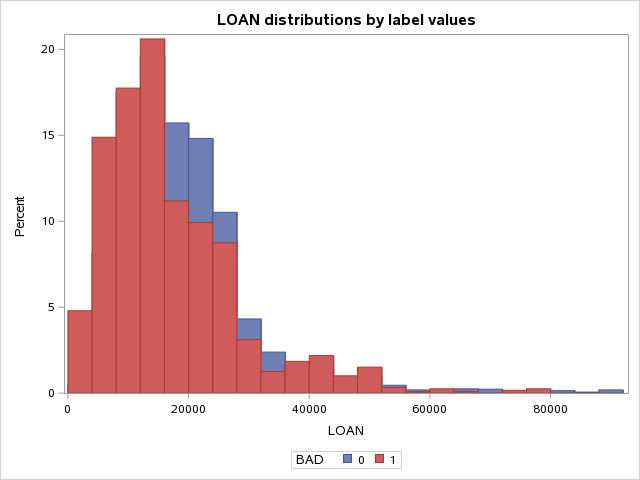

In [13]:
/*Plot in detail some predictors*/
PROC SGPLOT DATA=viyalab.hmeq;
    title "LOAN distributions by label values";
	histogram LOAN / GROUP=&label;
RUN;
title;

In [14]:
PROC FEDSQL SESSREF=casauto;
	create table summary2 as
		select %SYSFUNC(TRANwrd (&catFeatList, %STR( ), %STR(, ))), &label, count(1) as freq
		from csvfiles.hmeq
		group by %SYSFUNC(TRANwrd (&catFeatList, %STR( ), %STR(, ))), &label;
	quit;
RUN;

title "Frequency categorical feature analysis by label value";
PROC SQL;
		select job, sum(freq) as n_lev, sum(case when &label=0 then freq else . end)/calculated n_lev as label0 ,
			sum(case when &label=1 then freq else . end)/calculated n_lev as label1 
		from viyalab.summary2
		group by job;
		select REASON, sum(freq) as n_lev, sum(case when &label=0 then freq else . end)/calculated n_lev as label0 ,
			sum(case when &label=1 then freq else . end)/calculated n_lev as label1 
		from viyalab.summary2
		group by REASON;
QUIT;
title;

JOB,n_lev,label0,label1
,279,0.917563,0.082437
Mgr,767,0.766623,0.233377
Office,948,0.868143,0.131857
Other,2388,0.768007,0.231993
ProfExe,1276,0.833856,0.166144
Sales,109,0.651376,0.348624
Self,193,0.699482,0.300518
REASON,n_lev,label0,label1
,252,0.809524,0.190476
DebtCon,3928,0.810336,0.189664


In [15]:
/*2.4. Missing value analysis*/
/*Array and do loops does not run in CAS?*/

DATA viyalab.input_MI;
	set viyalab.hmeq END=eof;
	array numFeat {*}  &numFeatList;
	array numFeat_MI {*} &numFeatList_MI;
	
	array catFeat {*}  &catFeatList;
	array catFeat_MI {*} &catFeatList_MI;
	
	do i=1 to dim(numFeat);
		numFeat_MI[i] = cmiss(numFeat[i]);
	end;
	
	do i=1 to dim(catFeat);
		catFeat_MI[i] = cmiss(catFeat[i]);
		if catFeat_MI[i] then catFeat[i]="missing";
	end;
	tot_mis=sum(of catFeat_MI[*], of numFeat_MI[*]);
	DROP i;
	if eof then put _threadid_= _N_=;
RUN;

PROC MDSUMMARY DATA=viyalab.input_MI;
	var &featList_MI;
	GROUPBY &label / OUT=viyalab.summary_MI;
RUN;

DATA viyalab.summary_MI2;
	set viyalab.summary_MI;
	prop_MI=_Sum_/&NTot;
RUN;

title "Missing value observations per feature and label value";
PROC PRINT DATA=viyalab.summary_MI2;
	id _Column_ &label;
	var _Sum_;
RUN;


_Column_,BAD,_Sum_
CLAGE_MI,0,230
CLNO_MI,0,169
DEBTINC_MI,0,481
DELINQ_MI,0,508
DEROG_MI,0,621
JOB_MI,0,256
LOAN_MI,0,0
MORTDUE_MI,0,412
NINQ_MI,0,435
REASON_MI,0,204



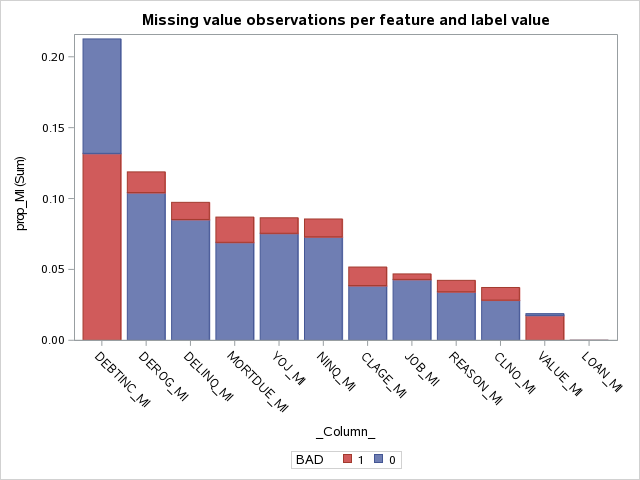

In [16]:
PROC SGPLOT DATA=viyalab.summary_MI2;
	vbar _Column_ / response= prop_MI group= &label datalabel=_Sum_ CATEGORYORDER= RESPDESC;
RUN;
title;

Debinc is the only above 20% of missing value observations, and proprotions of missing value are roughly equals at both values of the response.
Means of Debtinc are significantly different at both values of the response
_Mean_	(label=0)33.253128634	(label=1)39.387644892

Value missing proportion is significantly higher at positive response, but value means are roughly equals.
_Mean_	(label=0)102595.92102	(label=1)98172.846227

* Debtinc and value will be binned and rest of numerical features will be imputed by mean
* Categorical features missing is mapped to blank

## 3.Feature Engineering

In [17]:
/*3.1. Missing value imputation*/
DATA viyalab.featEng0;
	set viyalab.input_MI;
	DROP &numFeatList_MI &catFeatList_MI;
RUN;

proc varimpute data=viyalab.featEng0;
   input &numFeatList /ctech=mean;
   output out=viyalab.featEng1 copyvars=(_ALL_);
run;

In [18]:
/*3.2. Feature Binning*/
PROC BINNING DATA=viyalab.featEng1 METHOD=QUANTILE NUMBIN=10;
	input debtinc value;
	output OUT=viyalab.featEng2 COPYVARS=(_ALL_);
RUN;

## 4.Model Building

In [19]:
%LET numFeatList = IM_CLAGE IM_CLNO IM_DELINQ IM_DEROG IM_LOAN IM_MORTDUE IM_NINQ IM_YOJ BIN_DEBTINC BIN_VALUE tot_mis;
%PUT &numFeatList;
PROC PARTITION DATA=viyalab.featEng2 partition 
		samppct=70 /*_PartInd_=1*/
		samppct2=15 /*_PartInd_=2*/
		partind /*1{train}, 2{test}, 0{validation}*/
		;
  by &label;
  output OUT=viyalab.splits copyvars=(_ALL_);
RUN;

## 5.Model Assessment

In [50]:
/* Logistic Regresion */
ods select ModelInfo ParameterEstimates FitStatistics;
PROC LOGSELECT DATA=viyalab.splits NORMALIZE=YES;
  where _partind_ in (0, 1);
  class  &catFeatList / PARAM=GLM REF=FIRST;/*ONE-HOT-ENCODING, alphanumeric order of levels*/
  model &label(event='1')= &numFeatList &catFeatList;
  code file="&deployPath./logreg.sas" pcatall;
RUN;


In [40]:
/* Decision Tree */
ods select ModelInfo VariableImportance TreePerformance;
PROC TREESPLIT DATA=viyalab.splits
		MAXBRANCH=2 SPLITONCE
		MAXDEPTH=5
		MINLEAFSIZE=25
		PRUNINGTABLE
		SEED=123;
  input &numFeatList / level=interval;
  input &catFeatList / level=nominal;
  target &label / level=nominal;
  partition rolevar=_partind_(train='1' validate='0');
  grow entropy;
  prune c45;
  code file="&deployPath./tree.sas";
RUN;

In [41]:
/* Random Forest */
ods select ModelInfo VariableImportance;
PROC FOREST DATA=viyalab.splits ntrees=200 intervalbins=20 minleafsize=25 
        VOTE=PROBABILITY SEED=123;
  input &numFeatList / level=interval;
  input &catFeatList / level=nominal;
  target &label / level=nominal;
  partition rolevar=_partind_(train='1' validate='0');
  autotune useparameters=custom
           tuneparms=(INBAGFRACTION (VALUES=0.25 0.5 0.75)
           			  MAXDEPTH (VALUES=3 5 8)
           			 );
  code file="&deployPath./forest.sas";
  ods output FitStatistics=forestFit; 
RUN;


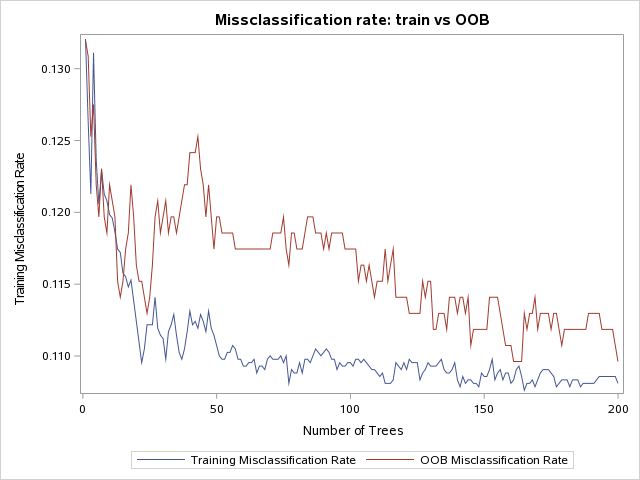
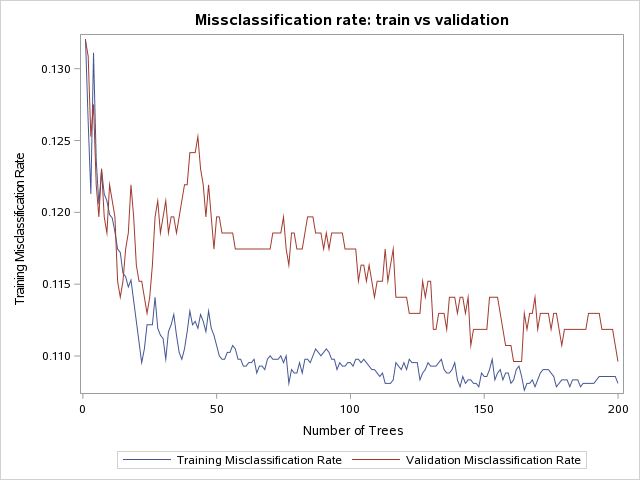

In [38]:
title "Missclassification rate: train vs OOB";
PROC SGPLOT DATA=forestFit;
	series x=trees y=miscTRAIN;
	series x=trees y=miscoob;
RUN;

title "Missclassification rate: train vs validation";
PROC SGPLOT DATA=forestFit;
	series x=trees y=miscTRAIN;
	series x=trees y=miscVALID;
RUN;

In [43]:
/*Gradient Boosted Trees*/
/*
* By default, SAMPLINGRATE=0.5.
* By default, VARS_TO_TRY is set to the number of input variables.
*/
ods select ModelInfo VariableImportance;

PROC GRADBOOST DATA=viyalab.splits intervalbins=20 maxdepth=5 MAXBRANCH=2 MINLEAFSIZE= 25 
        SEED=123; 
  input &numFeatList / level=interval;
  input &catFeatList / level=nominal;
  target &label / level=nominal;
  partition rolevar=_partind_(train='1' validate='0');
  autotune useparameters=custom
           tuneparms=(LASSO (VALUES=0.001 0.01 0.1 1 10)
           				RIDGE (VALUES=0.001 0.01 0.1 1 10)
           				NTREES(LB=50 UB=200 INIT=50)
       				);
  code file="&deployPath./GBM.sas";
  ods output FitStatistics=gbmFit; 
RUN;



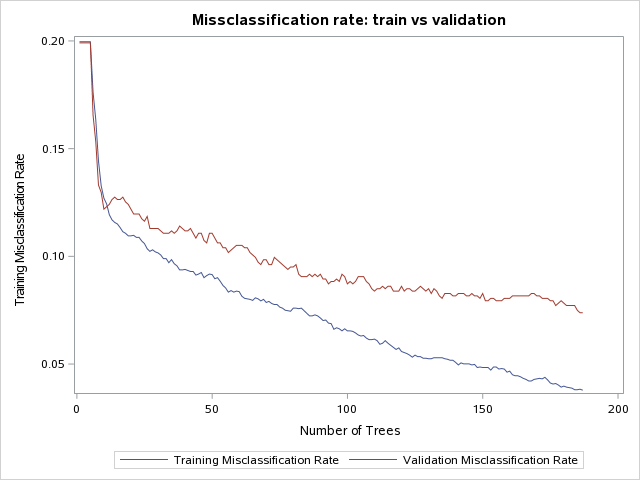

In [44]:
title "Missclassification rate: train vs validation";
PROC SGPLOT DATA=gbmFit;
	series x=trees y=miscTRAIN;
	series x=trees y=miscVALID;
RUN;
title;

## 5.Model Assessment

In [51]:
%ScoreAndAsses(data=viyalab.splits,path=&deployPath./logreg.sas,model=logreg, response=&label);
%ScoreAndAsses(data=viyalab.splits,path=&deployPath./tree.sas,model=tree, response=&label);
%ScoreAndAsses(data=viyalab.splits,path=&deployPath./forest.sas,model=forest, response=&label);
%ScoreAndAsses(data=viyalab.splits,path=&deployPath./GBM.sas,model=gbm, response=&label);

In [52]:
DATA roc;
	set roc_logreg(keep=sensitivity fpr c _partind_ in=l )
	roc_tree(keep=sensitivity fpr c _partind_ in=t )
	roc_forest(keep=sensitivity fpr c _partind_ in=f )
	roc_GBM(keep=sensitivity fpr c _partind_ in=g );
	length model dataset $ 16;
	select;
		when (l) model='Logistic';
		when (t) model='Tree';
		when (f) model='Forest';
		when (g) model='GBM';
		end;
	select (_PartInd_);
		when(0) dataset="validation";
		when(1) dataset="train";
		when(2) dataset="test";
	end;
RUN;

data lift;
  set lift_logreg(keep=depth lift cumlift _partind_ in=l)
      lift_tree(keep=depth lift cumlift _partind_ in=t)
      lift_forest(keep=depth lift cumlift _partind_ in=f)
      lift_gbm(keep=depth lift cumlift _partind_ in=g);
      
  length model dataset $ 16;
  select;
      when (l) model='Logistic';
      when (t) model='Tree';
      when (f) model='Forest';
	  when (g) model='GBM';
  end;
  select (_PartInd_);
	  	when(0) dataset="validation";
	  	when(1) dataset="train";
	  	when(2) dataset="test";
	  end;
run;

In [53]:
PROC SQL;
	create table AUROC as
		select distinct model, dataset, c from ROC order by model, dataset;
QUIT;

PROC TRANSPOSE DATA=AUROC OUT=AUROC_report;
	by model;
	id dataset;
	var c;
RUN;

PROC SQL;
	title "AUROC Report";
	select model, test, validation, train from AUROC_report order by test desc;
QUIT;
title;

model,test,validation,train
GBM,0.950050,0.953730,0.992676
Forest,0.888523,0.916907,0.914970
Tree,0.828008,0.841947,0.835393
Logistic,0.797537,0.846926,0.831654



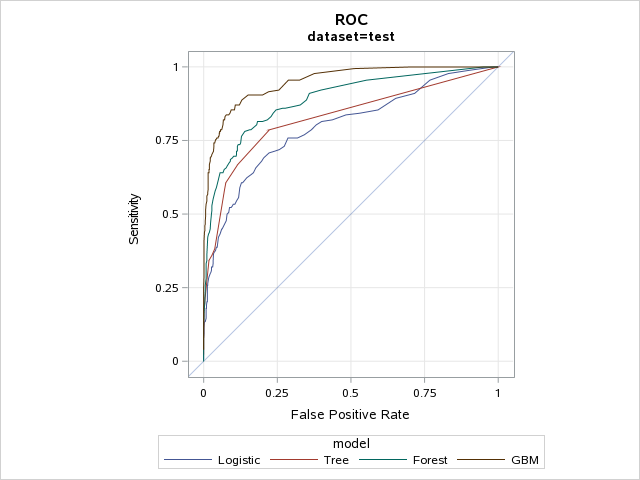
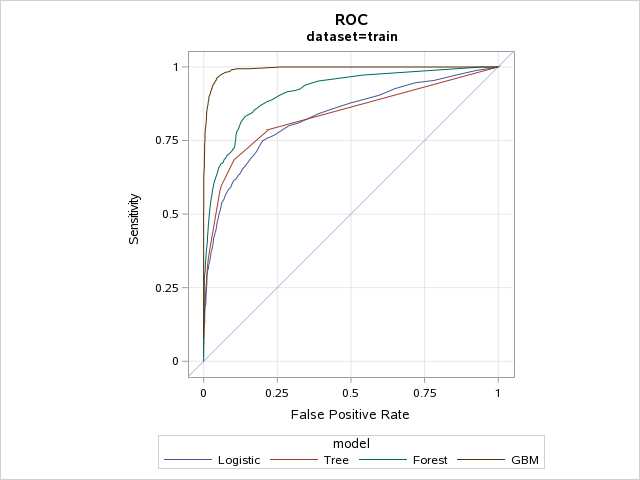
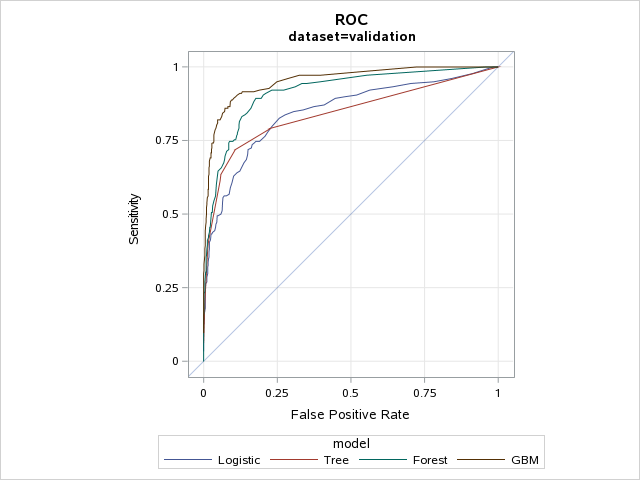

In [54]:
/* Draw ROC charts */ 
PROC SORT DATA=ROC;
	by dataset;
RUN;
proc sgplot data=roc aspect=1;
  title "ROC";
  by dataset;
  xaxis values=(0 to 1 by 0.25) grid offsetmin=.05 offsetmax=.05; 
  yaxis values=(0 to 1 by 0.25) grid offsetmin=.05 offsetmax=.05;
  lineparm x=0 y=0 slope=1 / transparency=.7;
  series x=fpr y=sensitivity / group=model;
run;


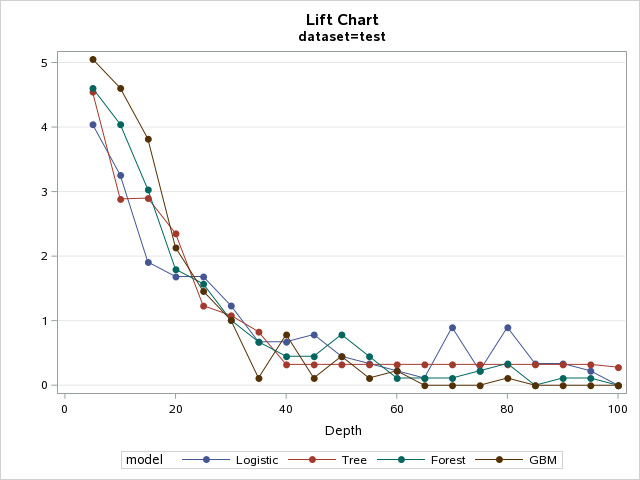
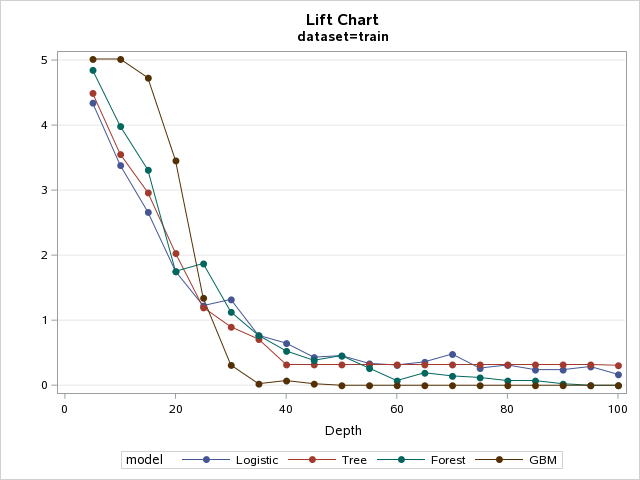
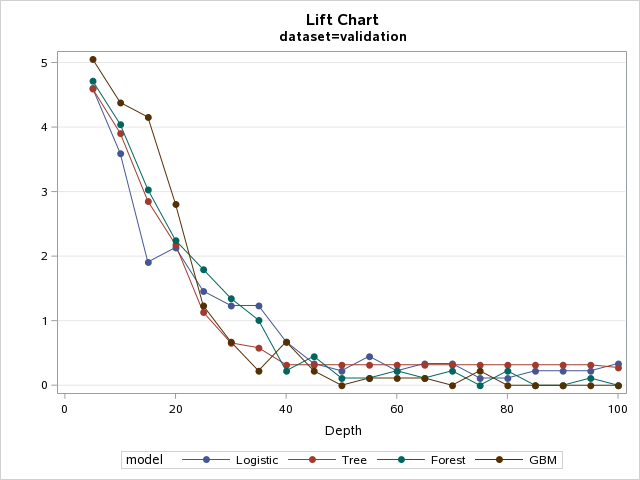

In [55]:
PROC SORT DATA=LIFT;
	by dataset;
RUN;
/* Draw lift charts */   
proc sgplot data=lift; 
  title "Lift Chart";
  by dataset;
  yaxis label=' ' grid;
  series x=depth y=lift / group=model markers markerattrs=(symbol=circlefilled);
run;
title;

As the GBM outperforms the rest of the models, we will persist the gbm scoring dataset in SASHDAT (distributed file format).

## 6. Scoring

In [49]:
proc casutil;
    save casdata="scored_gbm" 
    incaslib="csvfiles" 
    outcaslib="casuser"
	casout="hmeq_scored"
	replace;
run;

proc casutil;
    list tables incaslib="casuser";
run;